In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../')
from axia import report

from importlib import reload

# Load Subscription Data

In [3]:
with open("./jobber_working_data.pkl", "rb") as f:
    data = pickle.load(f)

In [4]:
data.df.head()

,start_date,end_date,age,alive,subscription_initial,subscription_last,subscription_current,frequency,country,industry
account_id,,,,,,,,,,
2,2011-04-01,NaT,95,1,65.0,128.0,128.0,monthly,canada,painting
34,2012-04-01,NaT,83,1,47.0,47.0,47.0,monthly,canada,arborist_/_tree_care
87,2014-04-01,2015-02-01,10,0,39.0,39.0,0.0,monthly,united_states,lawn_care_&_lawn_maintenance
109,2011-05-01,NaT,94,1,38.0,47.0,47.0,monthly,canada,painting
137,2016-03-01,2016-08-01,5,0,68.0,68.0,0.0,monthly,united_states,mechanical_service


# Traditional

The traditional approach calculates aggregate the quantities arpu, and churn, and uses them to project lifetime value forward.

## Global 

,avg_subscription_value,avg_arpu_6m,churn_rate,avg_churn_6m,expected_value_to_date
end_of_month,,,,,
2018-09-30,90.613533,87.937471,0.023274,0.022782,932.568986
2018-10-31,91.777890,89.093273,0.023617,0.022433,946.594816
2018-11-30,92.236983,90.114378,0.025810,0.023126,953.897974
2018-12-31,92.719686,90.991871,0.021996,0.023465,961.447767
2019-01-31,93.202350,91.748912,0.026001,0.024153,965.888373
2019-02-28,93.524997,92.345907,0.023665,0.024061,972.654461


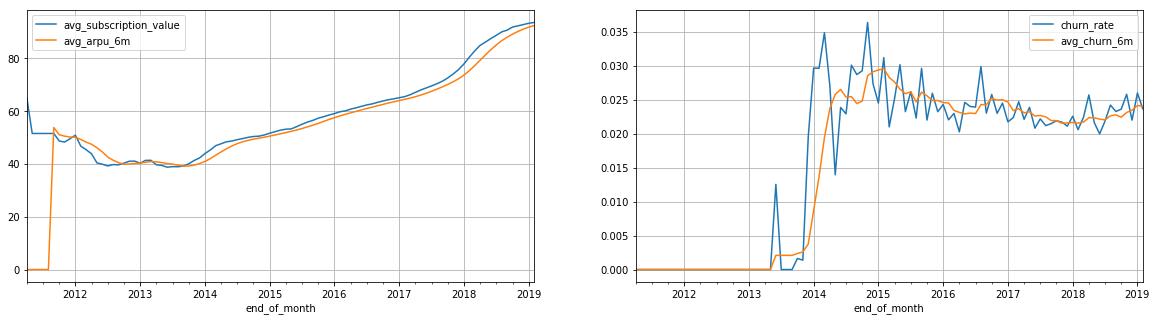

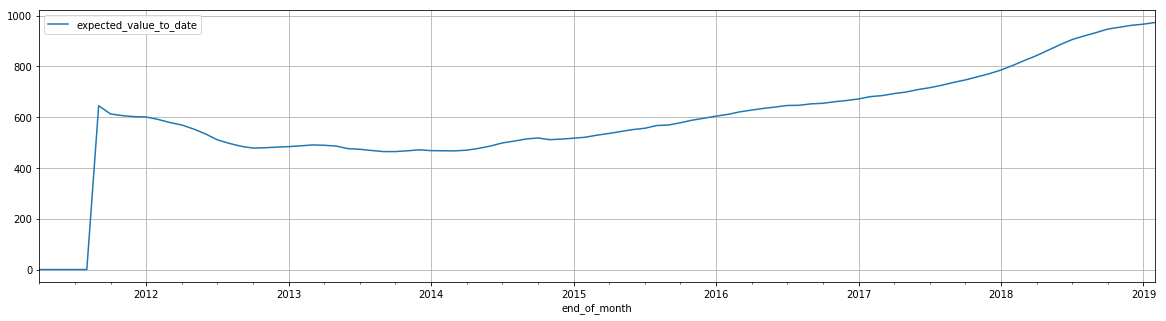

In [17]:
def _traditional_one_year_value(arpu, churn):
    return sum([arpu * (1 - churn) ** m for m in range(12)])

def _churn_rate(df):
    df["churn_rate"] = (df["is_cancelation_month"] / df["alive"]).fillna(0)
    df["avg_churn_6m"] = df['churn_rate'].rolling(window=6).mean().fillna(0)
    return df

def _arpu_progression(df):
    df["subscription_value_base"] = df["subscription_value_base"] / df["alive"]
    df["avg_arpu_6m"] = df["subscription_value_base"].rolling(window=6).mean().fillna(0)
    df = df.rename(columns={"subscription_value_base": "avg_subscription_value"})
    return df

def _expected_value_to_date(arpu, churn, periods=12):
    return sum([arpu * (1 - churn) ** m for m in range(periods)])

def _value_to_date(df):
    df["expected_value_to_date"] =  df.apply(
        lambda row: _expected_value_to_date(row["avg_arpu_6m"], row["avg_churn_6m"], 12),
        axis=1
    )
    return df



cdf = (
    data.cdf
    .groupby("end_of_month")
    .agg({
        'alive': "sum",
        "is_starting_month": 'sum',
        'is_cancelation_month': 'sum',
        "subscription_value_base": "sum",
    })
    .pipe(_arpu_progression)
    .pipe(_churn_rate)
    .pipe(_value_to_date)
    [["avg_subscription_value", "avg_arpu_6m", "churn_rate", 
      "avg_churn_6m", "expected_value_to_date"]]
)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
cdf.plot(y=["churn_rate", "avg_churn_6m"], ax=ax[1])
cdf.plot(y=["avg_subscription_value", "avg_arpu_6m"], ax=ax[0])
for axis in ax:
    axis.grid(True)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
cdf.plot(y=["expected_value_to_date"], ax=ax)
ax.grid(True)

cdf.tail(6)

## Cohort

Let's mix-in a cohort initial ARPU with the global churn trend to try and capture arpu changes.

,avg_arpu_6m,cohort_arpu,expected_value_to_date,expected_value_to_date_cohort
end_of_month,,,,
2017-09-30,69.144923,101.282723,736.548167,1078.887652
2017-10-31,70.055183,106.493506,746.382274,1134.603637
2017-11-30,71.058595,112.715640,758.547848,1203.235251
2017-12-31,72.218332,138.407821,770.726826,1477.112775
2018-01-31,73.606522,128.733577,785.272162,1373.395877
2018-02-28,75.282854,135.374172,803.587271,1445.016443
2018-03-31,77.196751,134.405634,823.326918,1433.477112


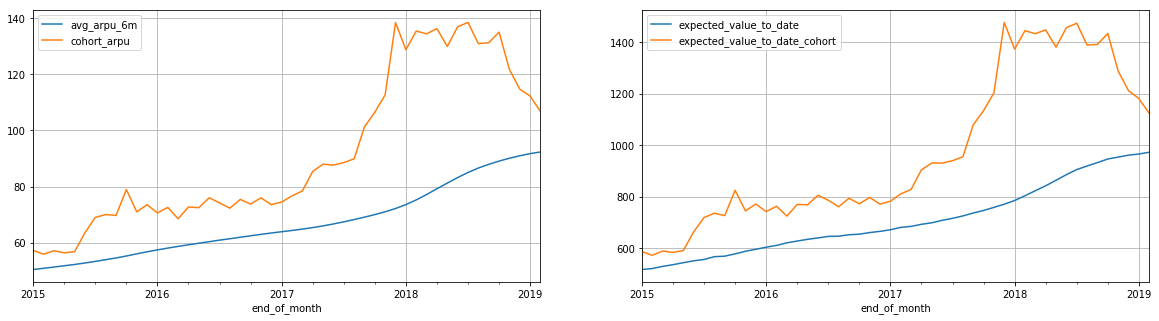

In [37]:
def _cohort_value_to_date(df):
    df = df.copy()
    df["expected_value_to_date_cohort"] =  df.apply(
        lambda row: _expected_value_to_date(row["cohort_arpu"], row["avg_churn_6m"], 12),
        axis=1
    )
    return df

cohort = (
    cdf.join(
        other=(
            data.cdtr
            .query("age == 0")
            .reset_index("end_of_month")
            .groupby("end_of_month")
            .agg({"subscription_value_base": "mean"})
            .rename(columns={"subscription_value_base": "cohort_arpu"})
        )
    )
    .fillna(method="ffill")
    .pipe(_cohort_value_to_date)
    [['avg_arpu_6m', 'cohort_arpu', 'expected_value_to_date', 'expected_value_to_date_cohort']]
    .loc["2015-01-01":]
)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
cohort.plot(y=["avg_arpu_6m", "cohort_arpu"], ax=ax[0])
cohort.plot(y=["expected_value_to_date", "expected_value_to_date_cohort"], ax=ax[1])
for axis in ax:
    axis.grid(True)

cohort.loc[:"2018-04-01"].tail(7)